In [1]:
import scripts
import numpy as np
import tensorflow as tf
import importlib

2023-04-17 23:33:55.337564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
importlib.reload(scripts)

<module 'scripts' from '/Users/alfred/Documents/chinese_mnist_analysis/scripts.py'>

# Solving Chinese MNIST using Transfer Learning

## Some Hyperparameters

In [15]:
NUMBER_OF_CLASSES = 15
IMAGE_SIZE = (64, 64)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

CLASSIFIER_LEARNING_RATE = 0.0001
CLASSFIER_NUMBER_OF_EPOCHS = 1
BATCH_SIZE = 1
OPTIMIZER = tf.keras.optimizers.Adam
LOSS_MEASURE = tf.keras.losses.SparseCategoricalCrossentropy

## Dataloaders

In [ ]:
debug_dataloader = tf.keras.utils.image_dataset_from_directory("./debug_dataset/",
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMAGE_SIZE,
                                                               seed=413)
validation_dataloader = tf.keras.utils.image_dataset_from_directory("./debug_dataset/",
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMAGE_SIZE,
                                                               seed=413)

### Take a Peek

Image batch shape = (32, 64, 64, 3)
Label batch shape = (32,)


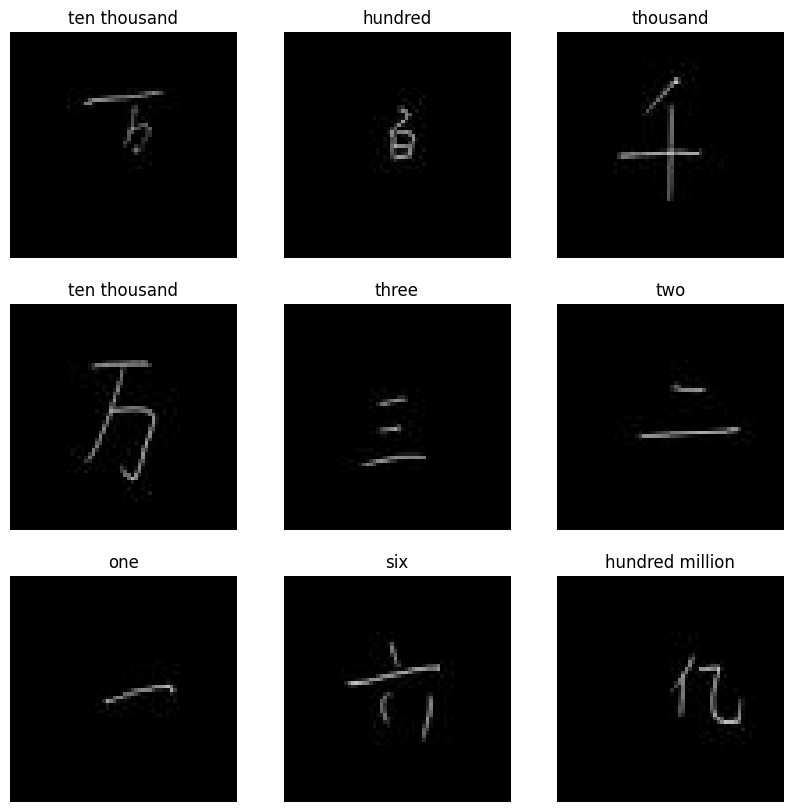

In [5]:
scripts.peek_into_dataloader(debug_dataloader)

### Cache and Prefetch

In [6]:
debug_dataloader = debug_dataloader.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataloader = validation_dataloader.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Base Models

In [7]:
small_efficientnet_base_model = tf.keras.applications.EfficientNetV2S(include_top=False, input_shape=IMAGE_SHAPE) # expects an input to be in the range [0, 255].
medium_efficientnet_base_model = tf.keras.applications.EfficientNetV2M(include_top=False, input_shape=IMAGE_SHAPE)
large_efficientnet_base_model = tf.keras.applications.EfficientNetV2L(include_top=False, input_shape=IMAGE_SHAPE)

### Full Models

In [8]:
small_efficientnet = scripts.add_classifier(small_efficientnet_base_model, IMAGE_SHAPE, NUMBER_OF_CLASSES)
medium_efficientnet = scripts.add_classifier(medium_efficientnet_base_model, IMAGE_SHAPE, NUMBER_OF_CLASSES)
large_efficientnet = scripts.add_classifier(large_efficientnet_base_model, IMAGE_SHAPE, NUMBER_OF_CLASSES)

### Inspection

In [9]:
print("Number of layers in the small efficientnet base model: {}".format(len(small_efficientnet.layers[1].layers)))
print("Number of layers in the medium efficientnet base model: {}".format(len(medium_efficientnet.layers[1].layers)))
print("Number of layers in the large efficientnet base model: {}".format(len(large_efficientnet.layers[1].layers)))

Number of layers in the small efficientnet base model: 513
Number of layers in the medium efficientnet base model: 740
Number of layers in the large efficientnet base model: 1028


In [10]:
small_efficientnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 2, 2, 1280)       20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 5120)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              5243904   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 15)                15375     
                                                             

In [11]:
medium_efficientnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 2, 2, 1280)       53150388  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              5243904   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 15)                15375     
                                                           

In [12]:
large_efficientnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 efficientnetv2-l (Functiona  (None, 2, 2, 1280)       117746848 
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 5120)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              5243904   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 15)                15375     
                                                           

## Training

In [13]:
CHECKPOINT_NAMES = np.array([["small_efficientnet_with_debug_dataset"],
                             ["medium_efficientnet_with_debug_dataset"],
                             ["large_efficientnet_with_debug_dataset"]])
MODELS = (small_efficientnet, medium_efficientnet, large_efficientnet)
OPTIMIZERS = (OPTIMIZER, OPTIMIZER, OPTIMIZER)
DATALOADERS = (debug_dataloader)

## Training a Classifier
Train the classifier of each of the three models using the medium dataset.

In [1]:
accuracies_after_training_classifiers = scripts.train_classifiers(MODELS,
                                                                  OPTIMIZERS,
                                                                  DATALOADERS,
                                                                  validation_dataloader,
                                                                  CLASSIFIER_LEARNING_RATE,
                                                                  LOSS_MEASURE(from_logits=True),
                                                                  CLASSFIER_NUMBER_OF_EPOCHS,
                                                                  CHECKPOINT_NAMES)

NameError: name 'scripts' is not defined

## Fine-Tuning

Only fine tune after the classifer have been trained.

### Some Hyperparameters

In [ ]:
FINE_TUNING_LEARNING_RATE = CLASSIFIER_LEARNING_RATE / 10
FINE_TUNING_NUMBER_OF_EPOCHS = 1
PERCENTAGE_OF_LAYERS_TO_FREEZE = [0.2, 0.4, 0.6]

In [ ]:
scripts.fine_tune(OPTIMIZERS,
                  DATALOADERS,
                  validation_dataloader,
                  FINE_TUNING_LEARNING_RATE,
                  LOSS_MEASURE(from_logits=True),
                  FINE_TUNING_NUMBER_OF_EPOCHS,
                  CHECKPOINT_NAMES,
                  PERCENTAGE_OF_LAYERS_TO_FREEZE)

## Results